In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt 
import os
from torchvision.utils import save_image
import random
from PIL import Image


In [16]:
if torch.cuda.is_available():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("GPU name:", torch.cuda.get_device_name(0))
    print("GPU count:", torch.cuda.device_count())

GPU name: NVIDIA GeForce GTX 1660 Ti
GPU count: 1


# LOAD DATASET

In [17]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [18]:
dataset_path = "./train" 

full_dataset = datasets.ImageFolder(
    root=dataset_path,
    transform=transform
)

In [19]:
print("Classes:", full_dataset.classes)
print("Total images:", len(full_dataset))

Classes: ['sunflower']
Total images: 500


In [20]:
val_ratio = 0.2
num_total = len(full_dataset)
num_val = int(num_total * val_ratio)
num_train = num_total - num_val

train_dataset, val_dataset = random_split(full_dataset, [num_train, num_val])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# A. Construct and train a deep learning model as an image generator by using the  images in your training dataset to train the model.

In [21]:
class VAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(VAE, self).__init__()
        
        # Encoder
        self.enc = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),  # 32x16x16
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1), # 64x8x8
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1), # 128x4x4
            nn.ReLU(True)
        )
        
        self.fc_mu = nn.Linear(128*4*4, latent_dim)
        self.fc_logvar = nn.Linear(128*4*4, latent_dim)

        # Decoder
        self.fc_dec = nn.Linear(latent_dim, 128*4*4)

        self.dec = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1), # 64x8x8
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # 32x16x16
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),  # 3x32x32
            nn.Sigmoid()  # [0,1]
        )

    def encode(self, x):
        h = self.enc(x)
        h = h.view(h.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(-1, 128, 4, 4)
        return self.dec(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [22]:
def vae_loss(recon, x, mu, logvar):
    recon_loss = F.mse_loss(recon, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (recon_loss + kl_loss) / x.size(0)

In [23]:
model = VAE().to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)

num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    # Train
    for imgs, _ in train_loader:
        imgs = imgs.to(device)

        recon, mu, logvar = model(imgs)
        loss = vae_loss(recon, imgs, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, _ in val_loader:
            imgs = imgs.to(device)
            recon, mu, logvar = model(imgs)
            loss = vae_loss(recon, imgs, mu, logvar)
            val_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{num_epochs}, Train={train_losses[-1]:.4f}, Val={val_losses[-1]:.4f}")


Epoch 1/100, Train=2034.8075, Val=1557.9387
Epoch 2/100, Train=1247.4046, Val=1101.6839
Epoch 3/100, Train=1080.1655, Val=1048.0610
Epoch 4/100, Train=1054.4357, Val=1034.5131
Epoch 5/100, Train=1045.7600, Val=1030.8569
Epoch 6/100, Train=1045.7198, Val=1025.2503
Epoch 7/100, Train=1043.3413, Val=1025.1343
Epoch 8/100, Train=1034.9078, Val=1016.0548
Epoch 9/100, Train=1019.0953, Val=996.2359
Epoch 10/100, Train=1016.2359, Val=993.3414
Epoch 11/100, Train=1002.9633, Val=984.3867
Epoch 12/100, Train=996.7812, Val=977.2704
Epoch 13/100, Train=996.5690, Val=969.7792
Epoch 14/100, Train=974.9971, Val=964.2002
Epoch 15/100, Train=969.2983, Val=958.8253
Epoch 16/100, Train=963.6347, Val=958.9179
Epoch 17/100, Train=961.2349, Val=954.3345
Epoch 18/100, Train=952.4804, Val=948.6105
Epoch 19/100, Train=957.6471, Val=948.7484
Epoch 20/100, Train=953.3866, Val=950.5664
Epoch 21/100, Train=951.6906, Val=940.2021
Epoch 22/100, Train=939.4261, Val=938.2379
Epoch 23/100, Train=936.6714, Val=936.2704
E

# B. Plot the training and validation losses

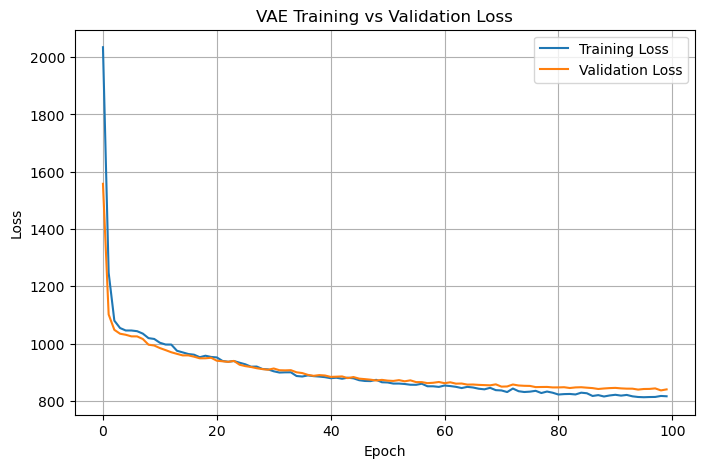

In [24]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Training vs Validation Loss")
plt.grid(True)
plt.legend()
plt.show()


# C. GENERATE 500 IMAGES

In [25]:
os.makedirs("generated", exist_ok=True)

model.eval()
num_images = 500

with torch.no_grad():
    for i in range(num_images):
        z = torch.randn(1, 64).to(device)  
        
        img = model.decode(z)

        save_image(img, f"generated/{i:04d}.png")

# D. COMPARE 10 IMAGES

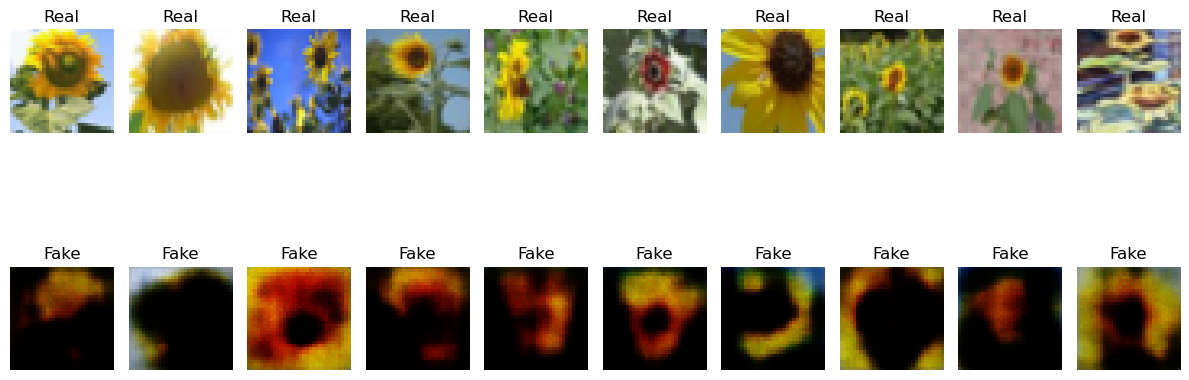

In [26]:
real_paths = [full_dataset.imgs[i][0] for i in random.sample(range(len(full_dataset)), 10)]

gen_paths = [f"generated/{i:04d}.png" for i in random.sample(range(500), 10)]

plt.figure(figsize=(12, 6))

for i, path in enumerate(real_paths):
    img = Image.open(path)
    plt.subplot(2, 10, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Real")

for i, path in enumerate(gen_paths):
    img = Image.open(path)
    plt.subplot(2, 10, 10 + i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Fake")

plt.tight_layout()
plt.show()
